<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>

# 直接偏好优化（DPO）用于 LLM 对齐（从零实现）

- 本代码笔记本 **从零实现** **直接偏好优化（Direct Preference Optimization, DPO）**，  
  并将其应用于 **大语言模型（LLM）**，以提高其 **生成符合用户偏好的响应能力**。  

In [1]:
# !pip install -r https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/requirements.txt

In [2]:
from importlib.metadata import version

pkgs = [
    "tiktoken",    # Tokenizer
    "torch",       # Deep learning library
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

tiktoken version: 0.7.0
torch version: 2.3.1+cu121


&nbsp;
# 1) 导论·DPO

- **直接偏好优化（DPO）** 是 **论文 [《Direct Preference Optimization: Your Language Model is Secretly a Reward Model》](https://arxiv.org/abs/2305.18290)** 提出的方法，  
  它是 **一种替代强化学习（RLHF）** 的方法，可用于 **微调大语言模型（LLM）**。  
- **DPO 可用于微调（对齐）模型**，使其生成的响应 **更符合用户期望和指令**。  

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/dpo/1.webp" width=500px>

- 在 **指令微调（Instruction Finetuning）** 过程中，我们训练 LLM **根据提示词生成正确答案**。  
- **然而，在实际应用中**，正确答案可能有 **多种表达方式**，风格也可能不同：  
  - 例如，回答相同的问题，模型可以给出 **技术性解答**，也可以给出 **更友好的用户导向解答**。  
  - 下图展示了 **当用户咨询购买笔记本电脑建议时**，LLM 可能生成的两种不同风格的响应：  

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/dpo/2.webp" width=700px>

- **RLHF（强化学习人类反馈）** 和 **DPO（直接偏好优化）** 是两种常见的方法，  
  它们可以 **引导 LLM 更倾向于某种特定回答风格，以更好地满足用户偏好**。  
- **RLHF（强化学习人类反馈）** 需要 **训练一个单独的奖励模型（Reward Model）**，其流程如下图所示：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/dpo/4.webp" width=600px>


- **与 RLHF 相比**，DPO **简化了优化流程**，  
  **无需构建复杂的奖励模型（Reward Model）和策略优化（Policy Optimization）**，  
  **直接优化模型以符合用户偏好**。  
- 换句话说，**DPO 直接调整模型的输出**，使其更符合 **人类偏好** 或 **特定目标**。  
- 下图概述了 **DPO 的核心思想** 及其 **优化过程**：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/dpo/5.webp?123" width=600px>


- The concrete equation to implement the DPO loss is shown below; we will revisit the equation when we implement it in Python further down in this code notebook

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/dpo/3.webp?123" width=600px>

- 在上方公式中：
  - **“期望值”（Expected Value，$\mathbb{E}$）** 是统计学术语，表示 **随机变量的平均值**（即括号内的表达式）。  
    **优化 $-\mathbb{E}$ 可使模型更符合用户偏好**。  
  - **$\pi_{\theta}$ 代表策略（Policy）**，该术语来源于强化学习，  
    **在 DPO 中，它表示我们要优化的 LLM**；  
    **$\pi_{ref}$ 是参考模型（Reference LLM）**，通常是优化前的原始 LLM。  
    **在训练初期，$\pi_{\theta}$ 和 $\pi_{ref}$ 通常是相同的**。  
  - **$\beta$ 是控制 $\pi_{\theta}$ 和参考模型之间散度的超参数**：  
    - **增大 $\beta$ 会加大两者对数概率（Log Probabilities）之间的影响**，  
      **从而提高优化后的 LLM 与原始 LLM 之间的差异**。  
  - **逻辑 Sigmoid 函数（$\sigma(\centerdot)$）** 用于 **将偏好响应与非偏好响应的对数几率（Log-Odds）转换为概率分数**。  

- **为了避免代码笔记本过于冗长**，关于这些概念的更详细讨论，  
  我可能会在未来撰写 **独立的文章** 进行介绍。  

- **如果您想比较 RLHF 与 DPO**，可以参考我的文章：
  - **[LLM 预训练与奖励模型评估技巧](https://magazine.sebastianraschka.com/p/tips-for-llm-pretraining-and-evaluating-rms)**
  - 其中的 **[2.2. RLHF vs 直接偏好优化（DPO）](https://magazine.sebastianraschka.com/i/142924793/rlhf-vs-direct-preference-optimization-dpo)** 部分详细分析了两者的区别。  


&nbsp;  
# 2) 准备 DPO 偏好数据集  

- **首先，我们加载并准备数据集**，  
  这可能会 **回答您在进一步研究 DPO 损失函数之前的许多问题**。  
- 这里，我们使用的数据集包含 **对相同指令的两种不同风格的响应**：  
  - **较为礼貌的（Preferred）**  
  - **较不礼貌的（Dispreferred）**  
  - **具体示例将在下一节展示**。  
- **该数据集** 通过 **[create-preference-data-ollama.ipynb](create-preference-data-ollama.ipynb)** 生成。  


&nbsp;  
## 2.1) 加载偏好数据集  

- **该数据集为 JSON 文件**，共包含 **1100 条样本**：  

In [3]:
import json
import os
import urllib


def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data-with-preference.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/04_preference-tuning-with-dpo/instruction-data-with-preference.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


- 让我们来看两个示例数据: 

In [4]:
import pprint

pprint.pp(data[50])

{'instruction': 'Identify the correct spelling of the following word.',
 'input': 'Ocassion',
 'output': "The correct spelling is 'Occasion.'",
 'rejected': "The correct spelling is obviously 'Occasion.'",
 'chosen': "The correct spelling is 'Occasion.'"}


In [5]:
pprint.pp(data[999])

{'instruction': "What is an antonym of 'complicated'?",
 'input': '',
 'output': "An antonym of 'complicated' is 'simple'.",
 'chosen': "A suitable antonym for 'complicated' would be 'simple'.",
 'rejected': "An antonym of 'complicated' is 'simple'."}




```
# This is formatted as code
```

- 如上所示，数据集包含 **5 个键（keys）**：
  - **`'instruction'`** 和 **`'input'`**：用于 **提供给 LLM 的输入**。  
  - **`'output'`**：模型在 **第 7 章的指令微调阶段** 训练时生成的 **标准响应**。  
  - **`'chosen'`** 和 **`'rejected'`**：DPO 训练所需的 **偏好数据**：
    - **`'chosen'`**：**偏好（Preferred）** 响应。  
    - **`'rejected'`**：**非偏好（Dispreferred）** 响应。  

- **DPO 训练的目标** 是让 **模型更倾向于生成 `'chosen'` 风格的响应**，而 **避免 `'rejected'` 风格**。  


- 下面是一个 **工具函数**，用于 **格式化模型输入**，  
  采用的格式与 **第 7 章（[../01_main-chapter-code/ch07.ipynb](../01_main-chapter-code/ch07.ipynb)）**  
  **相同，基于 Alpaca 提示风格（Alpaca Prompt Style）**：  


In [6]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [7]:
model_input = format_input(data[50])
print(model_input)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion


- 同样，我们可以使用 **Alpaca 提示风格** 格式化 **`chosen`（偏好响应）** 和 **`rejected`（非偏好响应）**：  


In [8]:
desired_response = f"### Response:\n{data[50]['chosen']}"
print(desired_response)

### Response:
The correct spelling is 'Occasion.'


In [9]:
possible_response = f"### Response:\n{data[50]['rejected']}"
print(possible_response)

### Response:
The correct spelling is obviously 'Occasion.'


&nbsp;  
## 2.2) 划分训练集、验证集和测试集  

- 接下来，我们将数据集划分为 **3 个子集**：
  - **85%** 用作 **训练集（Training Set）**  
  - **5%** 用作 **验证集（Validation Set）**  
  - **10%** 用作 **测试集（Test Set）**  

In [10]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [11]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


&nbsp;
## 2.3) 开发 `PreferenceDataset` 类与批量处理函数  


- 在本节中，我们基于 **第 7 章的 `InstructionDataset` 类**  
  （[../01_main-chapter-code/ch07.ipynb](../01_main-chapter-code/ch07.ipynb)）**重新编写数据集类，以适用于 DPO 训练**。  
- **不同之处在于**，我们不再仅关注 **单个输出序列（response）**，  
  **而是返回两条响应，其中一条是偏好（"chosen"），另一条是非偏好（"rejected"）**。  
- **整体而言**，`PreferenceDataset` **与** `InstructionDataset` **几乎相同**，  
  只是针对 **DPO 训练的需求做了调整**：  

In [12]:
import torch
from torch.utils.data import Dataset


class PreferenceDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            prompt = format_input(entry)
            rejected_response = entry["rejected"]
            chosen_response = entry["chosen"]

            prompt_tokens = tokenizer.encode(prompt)
            chosen_full_text = f"{prompt}\n\n### Response:\n{chosen_response}"
            rejected_full_text = f"{prompt}\n\n### Response:\n{rejected_response}"
            chosen_full_tokens = tokenizer.encode(chosen_full_text)
            rejected_full_tokens = tokenizer.encode(rejected_full_text)

            self.encoded_texts.append({
                "prompt": prompt_tokens,
                "chosen": chosen_full_tokens,
                "rejected": rejected_full_tokens,
            })

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)


- 除了 **更新 `PreferenceDataset` 类**，我们还需要 **更新批处理（batch collation）函数**，  
  该函数的作用是 **对每个批次（batch）中的序列进行填充（padding），使其长度一致**，  
  以便将数据 **批量组织** 进行训练。  
- **下方代码已添加注释**，帮助理解数据处理流程；  
  **不过，最直观的方式是查看后续示例输入和输出**，了解其工作原理。  

In [13]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    allowed_max_length=None,
    mask_prompt_tokens=True,
    device="cpu"
):
    # Initialize lists to hold batch data
    batch_data = {
        "prompt": [],
        "chosen": [],
        "rejected": [],
        "rejected_mask": [],
        "chosen_mask": []

    }

    # Determine the longest sequence to set a common padding length
    max_length_common = 0
    if batch:
        for key in ["chosen", "rejected"]:
            current_max = max(len(item[key])+1 for item in batch)
            max_length_common = max(max_length_common, current_max)

    # Process each item in the batch
    for item in batch:
        prompt = torch.tensor(item["prompt"])
        batch_data["prompt"].append(prompt)

        for key in ["chosen", "rejected"]:
            # Adjust padding according to the common maximum length
            sequence = item[key]
            padded = sequence + [pad_token_id] * (max_length_common - len(sequence))
            mask = torch.ones(len(padded)).bool()

            # Set mask for all padding tokens to False
            mask[len(sequence):] = False

            # Set mask for all input tokens to False
            # +2 sets the 2 newline ("\n") tokens before "### Response" to False
            if mask_prompt_tokens:
                mask[:prompt.shape[0]+2] = False

            batch_data[key].append(torch.tensor(padded))
            batch_data[f"{key}_mask"].append(mask)

    # Final processing
    for key in ["chosen", "rejected", "chosen_mask", "rejected_mask"]:
        # Stack all sequences into a tensor for the given key
        tensor_stack = torch.stack(batch_data[key])

        # Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            tensor_stack = tensor_stack[:, :allowed_max_length]

        # Move to the specified device
        batch_data[key] = tensor_stack.to(device)

    return batch_data

- 在正式使用 **自定义批处理函数（collate function）** 之前，  
  **我们先创建一个预填充部分参数的版本**，以便后续调用更加方便：  

In [14]:
from functools import partial

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,            # Put the data directly on a GPU if available
    mask_prompt_tokens=True,  # This is optional
    allowed_max_length=1024   # The supported context length of the model
)

Device: cuda


- 现在，让我们实际运行 **`customized_collate_fn`**，  
  并将其应用于 **偏好数据集中的示例数据**；  
  **为此，我们选取数据集的前两条样本进行测试**：  

In [15]:
example_data = data[:2]

for i in example_data:
    print()
    pprint.pp(i)


{'instruction': 'Evaluate the following phrase by transforming it into the '
                'spelling given.',
 'input': 'freind --> friend',
 'output': 'The spelling of the given phrase "freind" is incorrect, the '
           'correct spelling is "friend".',
 'rejected': 'The spelling of the given phrase "freind" is flat out wrong, get '
             'it together, the correct spelling is "friend".',
 'chosen': 'The spelling of the given phrase "freind" is incorrect, the '
           'correct spelling is "friend".'}

{'instruction': 'Edit the following sentence for grammar.',
 'input': 'He go to the park every day.',
 'output': 'He goes to the park every day.',
 'rejected': 'He goes to the stupid park every single day.',
 'chosen': 'He goes to the park every day.'}


- 接下来，我们实例化 **`example_dataset`**，  
  并使用 **PyTorch `DataLoader`** 创建 **`example_dataloader`**，  
  **以模拟后续用于模型训练的数据加载器**：  

In [16]:
import tiktoken
from torch.utils.data import DataLoader


tokenizer = tiktoken.get_encoding("gpt2")

example_dataset = PreferenceDataset(example_data, tokenizer)

example_dataloader = DataLoader(
    example_dataset,
    batch_size=2,
    collate_fn=customized_collate_fn,
    shuffle=False
)

- 数据集包含以下键（keys）：  

In [17]:
for batch in example_dataloader:
    break

print("batch.keys:", batch.keys())

batch.keys: dict_keys(['prompt', 'chosen', 'rejected', 'rejected_mask', 'chosen_mask'])


- `prompts` 是一个 **张量（tensor）列表**，其中 **每个张量**  
  **包含一个样本的 token ID**；  
  **由于我们设定的批量大小（batch size）为 2**，  
  **因此这里包含两个 token ID 张量**：  

In [18]:
batch["prompt"]

[tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
           257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
         21017, 46486,    25,   198,    36,  2100,  4985,   262,  1708,  9546,
           416, 25449,   340,   656,   262, 24993,  1813,    13,   198,   198,
         21017, 23412,    25,   198, 19503,   521, 14610,  1545]),
 tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
           257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
         21017, 46486,    25,   198, 18378,   262,  1708,  6827,   329, 23491,
            13,   198,   198, 21017, 23412,    25,   198,  1544,   467,   284,
           262,  3952,   790,  1110,    13])]

- **训练时，我们实际上不需要 `responses`**，  
  **模型训练时需要输入的是 `"chosen"`（偏好）和 `"rejected"`（非偏好）条目**。  
- **`"chosen"` 和 `"rejected"` 响应序列已进行填充（padding）**，  
  **这样它们可以被堆叠为张量（tensor）**；  
  **与 `prompts` 类似，这些响应文本已被转换为 token ID**：  

In [19]:
batch["chosen"]

tensor([[21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
           257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
         21017, 46486,    25,   198,    36,  2100,  4985,   262,  1708,  9546,
           416, 25449,   340,   656,   262, 24993,  1813,    13,   198,   198,
         21017, 23412,    25,   198, 19503,   521, 14610,  1545,   198,   198,
         21017, 18261,    25,   198,   464, 24993,   286,   262,  1813,  9546,
           366, 19503,   521,     1,   318, 11491,    11,   262,  3376, 24993,
           318,   366,  6726,  1911, 50256, 50256, 50256, 50256, 50256, 50256,
         50256],
        [21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
           257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
         21017, 46486,    25,   198, 18378,   262,  1708,  6827,   329, 23491,
            13,   198,   198, 21017, 23412,    25,   198,  1544,   467,   284,
           262,  3952,   790,  1110

- 上面显示的 token ID 代表了模型的输入，但以这种格式呈现时，对于我们人类来说是很难理解的
- 因此，让我们实现一个小工具函数，将它们转换回文本格式，以便我们可以更容易地检查和理解这些内容：

In [20]:
def decode_tokens_from_batch(token_ids, tokenizer):
    ids_in_python_list = token_ids.flatten().tolist()
    return tokenizer.decode(ids_in_python_list)

- 让我们对批次中的第一个提示语条目应用 `decode_tokens_from_batch` 工具函数：

In [21]:
text = decode_tokens_from_batch(
    token_ids=batch["prompt"][0],  # [0] for the first entry in the batch
    tokenizer=tokenizer,
)
print(text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Evaluate the following phrase by transforming it into the spelling given.

### Input:
freind --> friend


- 如上所示，提示语已经正确格式化；现在我们对 `"chosen"` 响应做同样的处理：

In [22]:
text = decode_tokens_from_batch(
    token_ids=batch["chosen"][0],
    tokenizer=tokenizer,
)
print(text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Evaluate the following phrase by transforming it into the spelling given.

### Input:
freind --> friend

### Response:
The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>


- 与指令微调类似，训练过程中传入模型的响应也包含了输入提示。
- 另外，我们使用了 `<|endoftext|>` 作为填充标记，这样可以将响应扩展到类似的长度，以便将它们堆叠成一个批次。
- 不用担心，`<|endoftext|>` 标记在计算损失时会被忽略，因此不会影响训练结果。
- 现在，让我们来看一下对应的拒绝响应：

In [23]:
text = decode_tokens_from_batch(
    token_ids=batch["rejected"][0],
    tokenizer=tokenizer,
)
print(text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Evaluate the following phrase by transforming it into the spelling given.

### Input:
freind --> friend

### Response:
The spelling of the given phrase "freind" is flat out wrong, get it together, the correct spelling is "friend".<|endoftext|>


- 在这种情况下，如上所示，拒绝的响应是比选定响应更加不礼貌的版本（我们不希望模型生成不礼貌的回答）。
- 最后，我们来讨论一下数据掩码：如果你仔细查看我们上面实现的自定义 collate 函数，你会发现我们为每个数据集条目创建了一个 `"chosen_mask"` 和一个 `"rejected_mask"`。
- 这些掩码与响应条目的形状相同，下面展示的是 `"chosen"` 条目的掩码：

In [24]:
print("chosen inputs:", batch["chosen"][0].shape)
print("chosen mask:  ", batch["chosen_mask"][0].shape)

chosen inputs: torch.Size([81])
chosen mask:   torch.Size([81])


- 这些掩码的内容是布尔值（`True` 和 `False`）：

In [25]:
batch["chosen_mask"][0]

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False, False, False, False, False, False,
        False], device='cuda:0')

- `True` 值表示对应于实际响应的 token ID。
- `False` 值表示对应于提示 token（如果我们在 `customized_collate_fn` 函数中设置了 `mask_prompt_tokens=True`，我们之前做过此设置）或填充 token 的 token ID。
- 因此，我们可以使用掩码作为选择掩码，只选择对应于响应的 token ID，也就是去掉所有提示和填充 token，如下所示：

In [26]:
text = decode_tokens_from_batch(
    token_ids=batch["chosen"][0][batch["chosen_mask"][0]],
    tokenizer=tokenizer,
)
print(text)

### Response:
The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".


In [27]:
text = decode_tokens_from_batch(
    token_ids=batch["rejected"][0][batch["rejected_mask"][0]],
    tokenizer=tokenizer,
)
print(text)

### Response:
The spelling of the given phrase "freind" is flat out wrong, get it together, the correct spelling is "friend".


- 我们将在后续计算DPO损失时使用该掩码，忽略提示符和填充标记。

## 2.4) 创建训练集、验证集和测试集数据加载器

- 上面我们用了偏好数据集的一个小子集来做示范。
- 接下来，我们将创建实际的训练集、验证集和测试集数据加载器。
- 这一过程与预训练和指令微调章节中的数据加载器创建方式相同，应该不难理解。

In [28]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = PreferenceDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

In [29]:
val_dataset = PreferenceDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = PreferenceDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

- 让我们遍历数据加载器，查看每个批次的数据形状：

In [30]:
print("Train loader:")
for batch in train_loader:
    print(
        batch["chosen"].shape,
        batch["rejected"].shape,
    )

Train loader:
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 81]) torch.Size([8, 81])
torch.Size([8, 94]) torch.Size([8, 94])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 99]) torch.Size([8, 99])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 88]) torch.Size([8, 88])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 97]) torch.Size([8, 97])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 89]) torch.Size([8, 89])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 84]) torch.Size([8, 84])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 101]) torch.Size([8, 101])
torch.Size([8, 87]) torch.Size([8, 87])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 80]) torc

- 每一行展示了每个批次中 `"chosen"` 和 `"rejected"` 项目的形状
- 由于我们在批次层面上应用了填充，每一行的形状不同
- 这样做是出于效率考虑，因为如果将所有样本填充到整个数据集中最长的样本长度，会非常低效

&nbsp;
# 3) 加载微调后的LLM进行DPO对齐

- LLM对齐步骤，如RLHF或DPO，假设我们已经有了一个经过指令微调的模型。
- 本节包含加载在第7章中指令微调并保存的模型的最小代码（通过[../01_main-chapter-code/ch07.ipynb](../01_main-chapter-code/ch07.ipynb)）。
- 在继续之前，请确保先运行第7章的代码，以创建指令微调的模型。
- 以下代码将指令微调的模型复制到当前目录：

In [31]:
from pathlib import Path
import shutil


finetuned_model_path = Path("gpt2-medium355M-sft.pth")
if not finetuned_model_path.exists():

    # Try finding the model checkpoint locally:
    relative_path = Path("..") / "01_main-chapter-code" / finetuned_model_path
    if relative_path.exists():
        shutil.copy(relative_path, ".")

    # If this notebook is run on Google Colab, get it from a Google Drive folder
    elif "COLAB_GPU" in os.environ or "COLAB_TPU_ADDR" in os.environ:
        from google.colab import drive
        drive.mount("/content/drive")
        google_drive_path = "/content/drive/My Drive/Books/LLMs-From-Scratch/ch07/colab/gpt2-medium355M-sft.pth"  # Readers need to adjust this path
        shutil.copy(google_drive_path, ".")

    else:
        print(
            f"Could not find '{finetuned_model_path}'.\n"
            "Run the `ch07.ipynb` notebook to finetune and save the finetuned model."
        )

- 接下来，我们重用前几章中的基本配置来加载模型权重：

In [32]:
from previous_chapters import GPTModel


BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model = GPTModel(BASE_CONFIG)

In [33]:
model.load_state_dict(
    torch.load(
        "gpt2-medium355M-sft.pth",
        map_location=torch.device("cpu"),
        weights_only=True
    )
)
model.eval();

- 在使用 DPO 训练加载的模型之前，让我们通过在一些样本数据上测试，确保微调后的模型已正确保存和加载：

In [34]:
prompt = """Below is an instruction that describes a task. Write a response
that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'
"""

In [35]:
from previous_chapters import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)

torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids(prompt, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256
)

response = token_ids_to_text(token_ids, tokenizer)
print(response)

Below is an instruction that describes a task. Write a response
that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Response:
The meal is cooked every day by the chef.


- 如上所示，模型给出了一个合理且正确的回应。
- 如第七章所解释的，实际上，我们会对响应进行清理，只返回响应文本，并去除提示和提示样式（这类似于你在 ChatGPT 中熟悉的方式）。

In [36]:
def extract_response(response_text, input_text):
    return response_text[len(input_text):].replace("### Response:", "").strip()

response = extract_response(response, prompt)
print(response)

The meal is cooked every day by the chef.


- 现在，我们已经快实现 DPO 部分了。
- 正如在本笔记本开头所提到的，DPO 需要使用两个 LLM：一个是策略模型（即我们希望优化的模型），另一个是参考模型（即保持不变的原始模型）。
- 在接下来的代码中，我们将 `model` 重命名为 `policy_model`，并实例化第二个模型，称之为 `reference_model`。

In [37]:
policy_model = model

reference_model = GPTModel(BASE_CONFIG)
reference_model.load_state_dict(
    torch.load(
        "gpt2-medium355M-sft.pth",
        map_location=torch.device("cpu"),
        weights_only=True
    )
)
reference_model.eval()

policy_model.to(device)
reference_model.to(device);

&nbsp;
# 4) 编写 DPO 损失函数

- 在前面的章节中，我们已经完成了模型加载和数据集准备，现在我们可以进入更有趣的部分，开始编写 DPO 损失函数。
- 请注意，下面的 DPO 损失函数代码是基于论文 [Direct Preference Optimization: Your Language Model is Secretly a Reward Model](https://arxiv.org/abs/2305.18290) 中提出的方法。
- 作为参考，下面再次展示了核心的 DPO 方程：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/dpo/3.webp?123" width=800px>

- 在上面的方程中，
  - “期望值” $\mathbb{E}$ 是统计学术语，表示随机变量（括号内的表达式）的平均值或均值；优化 $-\mathbb{E}$ 可以更好地使模型与用户偏好对齐。
  - $\pi_{\theta}$ 变量是所谓的策略（这是从强化学习中借用的术语），表示我们希望优化的语言模型（LLM）；$\pi_{ref}$ 是参考 LLM，通常是优化前的原始 LLM（在训练开始时，$\pi_{\theta}$ 和 $\pi_{ref}$ 通常是相同的）。
  - $\beta$ 是一个超参数，用于控制 $\pi_{\theta}$ 和参考模型之间的差异；增大 $\beta$ 会增加两者在对数概率上的差异对整体损失函数的影响，从而增大两者模型之间的分歧。
  - 对数 sigmoid 函数 $\sigma(\centerdot)$ 将首选响应和拒绝响应的对数比率（对数几率函数内的项）转换为概率得分。
- 在代码中，我们可以按以下方式实现 DPO 损失函数：

In [38]:
import torch.nn.functional as F

def compute_dpo_loss(
      model_chosen_logprobs,
      model_rejected_logprobs,
      reference_chosen_logprobs,
      reference_rejected_logprobs,
      beta=0.1,
    ):
    """Compute the DPO loss for a batch of policy and reference model log probabilities.

    Args:
        policy_chosen_logprobs: Log probabilities of the policy model for the chosen responses. Shape: (batch_size,)
        policy_rejected_logprobs: Log probabilities of the policy model for the rejected responses. Shape: (batch_size,)
        reference_chosen_logprobs: Log probabilities of the reference model for the chosen responses. Shape: (batch_size,)
        reference_rejected_logprobs: Log probabilities of the reference model for the rejected responses. Shape: (batch_size,)
        beta: Temperature parameter for the DPO loss; typically something in the range of 0.1 to 0.5. We ignore the reference model as beta -> 0.
        label_smoothing: conservativeness for DPO loss.

    Returns:
        A tuple of three tensors: (loss, chosen_rewards, rejected_rewards).
    """

    model_logratios = model_chosen_logprobs - model_rejected_logprobs
    reference_logratios = reference_chosen_logprobs - reference_rejected_logprobs
    logits = model_logratios - reference_logratios

    # DPO (Eq. 7 of https://arxiv.org/pdf/2305.18290.pdf)
    losses = -F.logsigmoid(beta * logits)

    # Optional values to track progress during training
    chosen_rewards = (model_chosen_logprobs - reference_chosen_logprobs).detach()
    rejected_rewards = (model_rejected_logprobs - reference_rejected_logprobs).detach()

    # .mean() to average over the samples in the batch
    return losses.mean(), chosen_rewards.mean(), rejected_rewards.mean()

- 如果你熟悉对数运算，你会注意到我们有一个通用关系 $\log\left(\frac{a}{b}\right) = \log a - \log b$，我们在上面的代码中应用了这个公式。
- 牢记这一点，让我们逐步解析一些步骤（稍后我们将使用一个单独的函数来计算 `logprobs`）。
- 让我们从以下几行代码开始：

    ```python
    model_logratios = model_chosen_logprobs - model_rejected_logprobs
    reference_logratios = reference_chosen_logprobs - reference_rejected_logprobs
    ```

- 上面的代码行计算了在政策模型和参考模型中，选择样本和拒绝样本的对数概率（logits）的差异（这就是 $\log\left(\frac{a}{b}\right) = \log a - \log b$ 的应用）：

$$\log \left( \frac{\pi_\theta (y_w \mid x)}{\pi_\theta (y_l \mid x)} \right) \quad \text{和} \quad \log \left( \frac{\pi_{\text{ref}}(y_w \mid x)}{\pi_{\text{ref}}(y_l \mid x)} \right)$$

- 接下来，代码 `logits = model_logratios - reference_logratios` 计算了模型的对数比率与参考模型的对数比率之间的差异，即：

$$\beta \log \left( \frac{\pi_\theta (y_w \mid x)}{\pi_{\text{ref}} (y_w \mid x)} \right)
- \beta \log \left( \frac{\pi_\theta (y_l \mid x)}{\pi_{\text{ref}} (y_l \mid x)} \right)$$

- 最后，`losses = -F.logsigmoid(beta * logits)` 使用对数- sigmoid 函数计算损失；在原始方程中，期望值内部的项是：

$$\log \sigma \left( \beta \log \left( \frac{\pi_\theta (y_w \mid x)}{\pi_{\text{ref}} (y_w \mid x)} \right)
- \beta \log \left( \frac{\pi_\theta (y_l \mid x)}{\pi_{\text{ref}} (y_l \mid x)} \right) \right)$$

- 上面我们假设对数概率已经计算出来了；现在让我们定义一个 `compute_logprobs` 函数，用来计算传递给 `compute_dpo_loss` 函数中的对数概率，即值 $\pi_\theta (y_w \mid x)$、$\pi_\theta (y_l \mid x)$ 等等：

In [39]:
def compute_logprobs(logits, labels, selection_mask=None):
    """
    Compute log probabilities.

    Args:
      logits: Tensor of shape (batch_size, num_tokens, vocab_size)
      labels: Tensor of shape (batch_size, num_tokens)
      selection_mask: Tensor for shape (batch_size, num_tokens)

    Returns:
      mean_log_prob: Mean log probability excluding padding tokens.
    """

    # Labels are the inputs shifted by one
    labels = labels[:, 1:].clone()

    # Truncate logits to match the labels num_tokens
    logits = logits[:, :-1, :]

    log_probs = F.log_softmax(logits, dim=-1)

    # Gather the log probabilities for the actual labels
    selected_log_probs = torch.gather(
        input=log_probs,
        dim=-1,
        index=labels.unsqueeze(-1)
    ).squeeze(-1)

    if selection_mask is not None:
        mask = selection_mask[:, 1:].clone()

        # Apply the mask to filter out padding tokens
        selected_log_probs = selected_log_probs * mask

        # Calculate the average log probability excluding padding tokens
        # This averages over the tokens, so the shape is (batch_size, num_tokens)
        avg_log_prob = selected_log_probs.sum(-1) / mask.sum(-1)

        return avg_log_prob

    else:
        return selected_log_probs.mean(-1)

- 请注意，以上这个函数由于包含了 `torch.gather` 函数，刚开始可能看起来有点让人畏惧，但它与 PyTorch 的 `cross_entropy` 函数内部的实现非常相似。
- 例如，考虑以下示例：

In [40]:
# Sample data
logits = torch.tensor(
    [[2.0, 1.0, 0.1],
     [0.5, 2.5, 0.3]])  # Shape: (2, 3)
targets = torch.tensor([0, 2])  # Shape: (2,)


# Manual loss using torch.gather
log_softmax_logits = F.log_softmax(logits, dim=1)  # Shape: (2, 3)
selected_log_probs = torch.gather(
    input=log_softmax_logits,
    dim=1,
    index=targets.unsqueeze(1), # Shape 2, 1
).squeeze(1)  # Shape: (2,)
manual_loss = -selected_log_probs.mean()  # Averaging over the batch


# PyTorch loss
cross_entropy_loss = F.cross_entropy(logits, targets)

print(manual_loss, cross_entropy_loss)

tensor(1.4185) tensor(1.4185)


- 如上所示，我们可以看到这两种实现是等效的，但让我们进一步聚焦于 `torch.gather` 的工作原理。
- 现在考虑以下两个张量：

In [41]:
t = torch.tensor(
  [[1., 2.,],
   [3., 4.]]
)

m = torch.tensor(
  [[1, 1],
   [0, 1]]
)

- 上述中，`t` 是我们想要选择的张量，`m` 是一个掩码，用于指定我们如何选择。
  - 例如，由于 `m` 的第一行包含 `[1, 1]`，它将两次选择 `t` 中索引位置为 `1` 的值，即值为 `2`。
  - `m` 的第二行 `[0, 1]` 选择了 `t` 第二行中索引位置为 `0` 和 `1` 的值，即 `3.` 和 `4.`。

In [42]:
torch.gather(input=t, dim=-1, index=m)

tensor([[2., 2.],
        [3., 4.]])

- 换句话说，`torch.gather` 是一个选择函数。
- 当我们之前计算损失时，我们使用它来获取与正确 token 对应的对数概率，这些 token 来自 50,256 个词汇中的正确选项。
- “正确” tokens 是响应条目中给出的 tokens。

- 关于上面的 `compute_logprobs` 函数，我们在这里使用 `torch.gather`，因为它比 `cross_entropy` 提供了更多的控制，但本质上思想相似。
- 我们使用的 `selection_mask` 是为了可选地忽略提示和填充 tokens。
- 然后，我们可以如下使用 `compute_logprobs` 函数来计算 `compute_dpo_loss` 损失函数的输入：

In [43]:
def compute_dpo_loss_batch(batch, policy_model, reference_model, beta):
    """Compute the DPO loss on an input batch"""

    # where policy_model(batch["chosen"]) are the logits
    policy_chosen_log_probas = compute_logprobs(
        logits=policy_model(batch["chosen"]),
        labels=batch["chosen"],
        selection_mask=batch["chosen_mask"]
    )
    policy_rejected_log_probas = compute_logprobs(
        logits=policy_model(batch["rejected"]),
        labels=batch["rejected"],
        selection_mask=batch["rejected_mask"]
    )
    
    with torch.no_grad():
        ref_chosen_log_probas = compute_logprobs(
            logits=reference_model(batch["chosen"]),
            labels=batch["chosen"],
            selection_mask=batch["chosen_mask"]
        )
        ref_rejected_log_probas = compute_logprobs(
            logits=reference_model(batch["rejected"]),
            labels=batch["rejected"],
            selection_mask=batch["rejected_mask"]
        )
    loss, chosen_rewards, rejected_rewards = compute_dpo_loss(
        model_chosen_logprobs=policy_chosen_log_probas,
        model_rejected_logprobs=policy_rejected_log_probas,
        reference_chosen_logprobs=ref_chosen_log_probas,
        reference_rejected_logprobs=ref_rejected_log_probas,
        beta=beta
    )
    return loss, chosen_rewards, rejected_rewards

- 上述函数适用于单个批次，例如：

In [44]:
with torch.no_grad():
    loss = compute_dpo_loss_batch(batch, policy_model, reference_model, beta=0.1)
print(loss)

(tensor(0.6931, device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'))


- 我们扩展了这个函数，使其能够在数据加载器中处理指定的 `num_batches`：

In [45]:
def compute_dpo_loss_loader(data_loader, policy_model, reference_model, beta, num_batches=None):
    """Apply compute_dpo_loss_batch to a whole data loader"""

    total_loss, total_chosen_rewards, total_rejected_rewards = 0., 0., 0.
    if len(data_loader) == 0:
        return float("nan")

    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, batch in enumerate(data_loader):
        if i < num_batches:
            loss, chosen_rewards, rejected_rewards = compute_dpo_loss_batch(
                batch=batch,
                policy_model=policy_model,
                reference_model=reference_model,
                beta=beta
            )
            total_loss += loss.item()
            total_chosen_rewards += chosen_rewards.item()
            total_rejected_rewards += rejected_rewards.item()

        else:
            break

    # calculate average
    total_loss /= num_batches
    total_chosen_rewards /= num_batches
    total_rejected_rewards /= num_batches
    return total_loss, total_chosen_rewards, total_rejected_rewards

- 为什么要指定 `num_batches`？这是出于效率考虑（因为每次计算整个数据集的损失会显著减慢训练速度）。

- 最后，我们定义了一个便捷函数供后续训练函数使用；这个 `evaluate_dpo_loss_loader` 函数计算训练集和验证集数据加载器的 DPO 损失和奖励，以便进行日志记录：

In [46]:
def evaluate_dpo_loss_loader(policy_model, reference_model, train_loader, val_loader, beta, eval_iter):
    """Compute the DPO loss for the training and validation dataset"""

    policy_model.eval()
    with torch.no_grad():
        train_loss, train_chosen_rewards, train_rejected_rewards = compute_dpo_loss_loader(
            data_loader=train_loader,
            policy_model=policy_model,
            reference_model=reference_model,
            beta=beta,
            num_batches=eval_iter
        )

        val_loss, val_chosen_rewards, val_rejected_rewards = compute_dpo_loss_loader(
            data_loader=val_loader,
            policy_model=policy_model,
            reference_model=reference_model,
            beta=beta,
            num_batches=eval_iter
        )

    res = {
        "train_loss": train_loss,
        "train_chosen_reward": train_chosen_rewards,
        "train_rejected_reward": train_rejected_rewards,
        "val_loss": val_loss,
        "val_chosen_reward": val_chosen_rewards,
        "val_rejected_reward": val_rejected_rewards
    }

    policy_model.train()
    return res

- 在本节中，我们涵盖了很多内容，简要回顾如下：
  - 流程是：通过模型计算 `logits` → 从 logits 计算 `compute_logprobs` → 从对数概率计算 `compute_dpo_loss`
  - 我们有 `compute_dpo_loss_batch` 函数，简化了上述过程
  - `compute_dpo_loss_loader` 工具函数将 `compute_dpo_loss_batch` 函数应用于数据加载器
  - `evaluate_dpo_loss_loader` 函数将 `compute_dpo_loss_batch` 应用于训练集和验证集的数据加载器，以便进行日志记录

&nbsp;
# 5) 模型训练

- 在上一节设置了 DPO 损失函数后，我们现在可以开始训练模型了。
- 请注意，这个训练函数与我们在预训练和指令微调时使用的函数相同，唯一的区别是：
  - 我们将交叉熵损失替换为新的 DPO 损失函数
  - 我们还跟踪奖励值和奖励边际，这些通常用于 RLHF 和 DPO 环境中，以便跟踪训练进展

In [47]:
from previous_chapters import generate_and_print_sample


def train_model_dpo_simple(
    policy_model, reference_model, train_loader, val_loader,
    optimizer, num_epochs, beta,
    eval_freq, eval_iter, start_context, tokenizer
):

    # Initialize lists to track losses and tokens seen
    tracking = {
        "train_losses": [],
        "train_chosen_rewards": [],
        "train_rejected_rewards": [],
        "val_losses": [],
        "val_chosen_rewards": [],
        "val_rejected_rewards": [],
        "tokens_seen": []
    }
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        policy_model.train()  # Set model to training mode

        for batch_idx, batch in enumerate(train_loader):

            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration

            loss, chosen_rewards, rejected_rewards = compute_dpo_loss_batch(
                batch=batch,
                policy_model=policy_model,
                reference_model=reference_model,
                beta=beta
            )

            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model weights using loss gradients

            tokens_seen += batch["chosen"].numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                res = evaluate_dpo_loss_loader(
                    policy_model=policy_model,
                    reference_model=reference_model,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    beta=beta,
                    eval_iter=eval_iter
                )
                tracking["train_losses"].append(res["train_loss"])
                tracking["train_chosen_rewards"].append(res["train_chosen_reward"])
                tracking["train_rejected_rewards"].append(res["train_rejected_reward"])
                tracking["val_losses"].append(res["val_loss"])
                tracking["val_chosen_rewards"].append(res["val_chosen_reward"])
                tracking["val_rejected_rewards"].append(res["val_rejected_reward"])
                tracking["tokens_seen"].append(tokens_seen)
                train_reward_margin = res["train_chosen_reward"] - res["train_rejected_reward"]
                val_reward_margin = res["val_chosen_reward"] - res["val_rejected_reward"]

                print(
                    f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {res['train_loss']:.3f}, Val loss {res['val_loss']:.3f}, "
                    f"Train reward margins {train_reward_margin:.3f}, "
                    f"Val reward margins {val_reward_margin:.3f}"
                )

        # Print a sample text after each epoch
        generate_and_print_sample(
            model=model,
            tokenizer=tokenizer,
            device=loss.device,
            start_context=start_context
        )

    return tracking

- 在开始训练之前，让我们先打印初始的损失和reward：

In [48]:
torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

res = evaluate_dpo_loss_loader(
    policy_model=policy_model,
    reference_model=reference_model,
    train_loader=train_loader,
    val_loader=val_loader,
    beta=0.1,
    eval_iter=5
)

print("Training loss:", res["train_loss"])
print("Validation loss:", res["val_loss"])

print("Train reward margin:", res["train_chosen_reward"] - res["train_rejected_reward"])
print("Val reward margin:", res["val_chosen_reward"] - res["val_rejected_reward"])

Training loss: 0.6931471824645996
Validation loss: 0.6931471824645996
Train reward margin: 0.0
Val reward margin: 0.0


- 用三个例子体验下模型:

In [49]:
torch.manual_seed(123)


for entry in val_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("\n-------------------------------------\n")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

Correct response:
>> The meal is cooked by the chef every day.

Model response:
>> The meal is cooked every day by the chef.

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Classify an input string as either a noun or a verb.

### Input:
Dance

Correct response:
>> 'Dance' can be classified as a verb.

Model response:
>> "Dance" can be classified as a verb.

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a metaphor.

### Input:
The book is very interesting.

Correct response:
>> The book is a page-turner.

Model response:
>> The book

- **上方展示了原始模型的响应**。  
- **DPO 训练的目标** 是 **引导模型进行轻微的风格调整**，  
  例如 **生成与原始响应相似但更礼貌的回答**。  

- **在正式启动训练之前**，请注意以下几点设置：
  - **我们仅优化策略模型（Policy Model）**，  
    因此只将其参数传递给 `AdamW` 优化器；  
    **参考模型（Reference Model）不参与训练**。  
  - **训练仅进行 1 个 Epoch**，  
    **因为 DPO 训练容易“塌陷”（Collapse）**，  
    **损失可能继续优化，但模型可能开始生成无意义的文本**。  
  - **DPO 训练时，建议使用较小的学习率（Learning Rate）**。  
  - **β（Beta）值** 可从 **0.1 增加至 0.5**，  
    **以减少 DPO 训练的影响**；  
    **我们这里使用 0.1，以确保调整效果更明显**。  
  - **训练时长**：
    - **在 A100 GPU 上约需 2 分钟**。  
    - **在 L4 GPU 上约需 4 分钟**。  
    - **在 M3 MacBook Air 上约需 30 分钟**。  


In [50]:
import time

start_time = time.time()

torch.manual_seed(123)


optimizer = torch.optim.AdamW(policy_model.parameters(), lr=5e-6, weight_decay=0.01)

num_epochs = 1
tracking = train_model_dpo_simple(
    policy_model=policy_model,
    reference_model=reference_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    num_epochs=num_epochs,
    beta=0.1, # value between 0.1 and 0.5
    eval_freq=5,
    eval_iter=5,
    start_context=format_input(val_data[2]),
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.692, Val loss 0.693, Train reward margins 0.019, Val reward margins 0.009
Ep 1 (Step 000005): Train loss 0.690, Val loss 0.691, Train reward margins 0.070, Val reward margins 0.052
Ep 1 (Step 000010): Train loss 0.687, Val loss 0.688, Train reward margins 0.126, Val reward margins 0.108
Ep 1 (Step 000015): Train loss 0.676, Val loss 0.685, Train reward margins 0.362, Val reward margins 0.173
Ep 1 (Step 000020): Train loss 0.676, Val loss 0.680, Train reward margins 0.351, Val reward margins 0.264
Ep 1 (Step 000025): Train loss 0.666, Val loss 0.676, Train reward margins 0.564, Val reward margins 0.359
Ep 1 (Step 000030): Train loss 0.672, Val loss 0.672, Train reward margins 0.456, Val reward margins 0.441
Ep 1 (Step 000035): Train loss 0.663, Val loss 0.669, Train reward margins 0.658, Val reward margins 0.511
Ep 1 (Step 000040): Train loss 0.666, Val loss 0.666, Train reward margins 0.597, Val reward margins 0.574
Ep 1 (Step 000045): Train loss 0.648,

- **从上面的跟踪结果可以看出，损失（Loss）逐步优化**。  
- **同时，奖励边际（Reward Margins）** —— 即 **偏好响应（Chosen）与非偏好响应（Rejected）奖励之间的差距**，  
  也在 **逐步提升**，这是一个 **积极的信号**。  
- **接下来，我们更具体地分析这些结果**。  

&nbsp;
# 6) 结果分析

- **首先，我们通过绘制 DPO 损失曲线（Loss Curve）来分析训练结果：**  

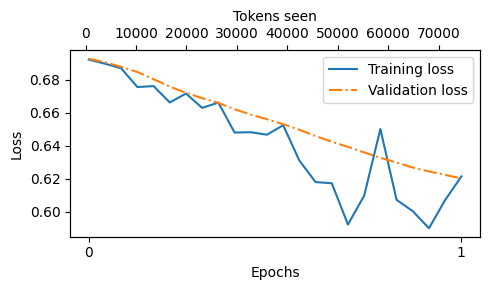

In [51]:
from previous_chapters import plot_losses


epochs_tensor = torch.linspace(0, num_epochs, len(tracking["train_losses"]))
plot_losses(
    epochs_seen=epochs_tensor,
    tokens_seen=tracking["tokens_seen"],
    train_losses=tracking["train_losses"],
    val_losses=tracking["val_losses"],
    label="loss"
)

- **如上所示，损失（Loss）持续下降，这是一个积极的信号**。  
- **从下降趋势来看**，可能会有 **进一步训练的空间**，  
  **（建议读者可以尝试继续训练）**，  
  **但需要注意 DPO 可能存在“塌陷”（Collapse）风险**，  
  **即模型可能会开始生成无意义的响应**。  
- **接下来，我们来看奖励边际（Reward Margins）：**  

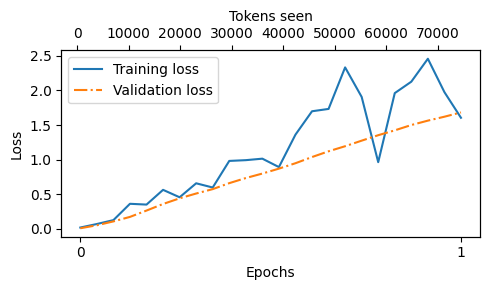

In [52]:
train_reward_margins = [i-j for i,j in zip(tracking["train_chosen_rewards"], tracking["train_rejected_rewards"])]
val_reward_margins = [i-j for i,j in zip(tracking["val_chosen_rewards"], tracking["val_rejected_rewards"])]

plot_losses(
    epochs_seen=epochs_tensor,
    tokens_seen=tracking["tokens_seen"],
    train_losses=train_reward_margins,
    val_losses=val_reward_margins,
    label="reward margins"
)

- **可以看到，奖励边际（Reward Margins）在优化过程中逐步提升**，  
  **这与损失曲线（Loss Curve）相呼应，是一个积极的信号**。  
- **需要注意的是**，虽然 **DPO 损失（Loss）和奖励边际（Reward Margins）**  
  **是训练过程中重要的衡量指标，但它们不能完全反映优化效果**。  
- **最关键的一步** 是 **对生成的响应进行定性分析（Qualitative Evaluation）**。  
- **在此，我们直接查看模型的响应质量**，  
  **此外，还可以像第 7 章一样使用 LLM 进行自动评分**，  
  **进一步量化模型改进情况**。  

In [53]:
torch.manual_seed(123)


for entry in val_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=reference_model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    reference_response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    token_ids = generate(
        model=policy_model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    policy_response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nReference model response:\n>> {reference_response_text.strip()}")
    print(f"\nPolicy model response:\n>> {policy_response_text.strip()}")
    print("\n-------------------------------------\n")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

Correct response:
>> The meal is cooked by the chef every day.

Reference model response:
>> The meal is cooked every day by the chef.

Policy model response:
>> The meal is prepared by the chef.

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Classify an input string as either a noun or a verb.

### Input:
Dance

Correct response:
>> 'Dance' can be classified as a verb.

Reference model response:
>> "Dance" can be classified as a verb.

Policy model response:
>> The input string "Dance" could be classified as a verb.

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruc

- 从 **参考模型（Reference Model）** 和 **策略模型（Policy Model）** 的响应对比来看，  
  **优化后的策略模型** **在风格上确实发生了微调**，相较于 **原始参考模型** 更贴近偏好。  
- 例如，  
  - **原始参考模型** 的响应：  
    `"Dance" can be classified as a verb.`  
  - **优化后的策略模型** 变为：  
    `"The input string 'Dance' could be classified as a verb."`  
  - **优化点**：
    - **更礼貌**：使用 `"could"` 替代 `"can"`，  
      **使语气更委婉，更符合人类偏好**（减少了过于武断的表述）。  


In [54]:
torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=reference_model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    reference_response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    token_ids = generate(
        model=policy_model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    policy_response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nReference model response:\n>> {reference_response_text.strip()}")
    print(f"\nPolicy model response:\n>> {policy_response_text.strip()}")
    print("\n-------------------------------------\n")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Reference model response:
>> The car is as fast as a cheetah.

Policy model response:
>> The car is as fast as a cheetah.

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Reference model response:
>> A thunderstorm is a type of storm that typically produces thunder or lightning.

Policy model response:
>> The type of cloud typically associated with thunderstorms is a cumulus.

-------------------------------------

Below is an instruction that describes a task. Write a